# Demonstrating new Designer API

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [2]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Random molecule from Enamine REAL.

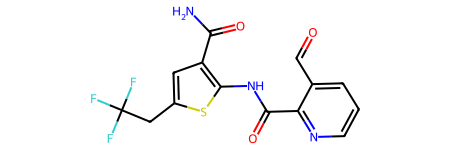

CPU times: user 1.76 s, sys: 108 ms, total: 1.87 s
Wall time: 708 ms


In [3]:
%%time
designer.reset_cache()
res = designer.design(1)[0]
display(res)

Multi-step reaction.

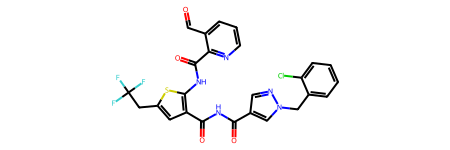

CPU times: user 155 ms, sys: 0 ns, total: 155 ms
Wall time: 15.5 ms


In [4]:
%%time
designer.reset_cache()
molecule = designer.design(res, size=1, method='grow')[0]
display(molecule)

Replace reactants in fragment.

CPU times: user 1.33 s, sys: 31.2 ms, total: 1.36 s
Wall time: 142 ms


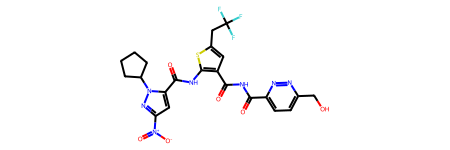

In [8]:
%%time
molecule = designer.design(molecule, 1, temperature=0.1)[0]
molecule

In [6]:
import json

print(json.dumps(molecule.dump(), indent=4))

{
    "product": "NC(=O)c1cc(CC(F)(F)F)sc1N(C(=O)c1cnn(Cc2ccccc2Cl)c1)C(=O)c1ncccc1C=O",
    "reaction": "13_Carboxylate_and_Amine",
    "reactants": [
        {
            "product": "NC(=O)c1cc(CC(F)(F)F)sc1NC(=O)c1ncccc1C=O",
            "reaction": "13_Carboxylate_and_Amine",
            "reactants": [
                {
                    "product": "Cl.O=Cc1cccnc1C(=O)O"
                },
                {
                    "product": "NC(=O)c1cc(CC(F)(F)F)sc1N"
                }
            ]
        },
        {
            "product": "O=C(O)c1cnn(Cc2ccccc2Cl)c1"
        }
    ]
}
